In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv(r"C:\Users\radha\AgriSight-Analytics-Platform\data\Crop_recommendation_messy.csv")

In [7]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (2211, 8)


In [8]:
print(f"Columns: {list(df.columns)}")

Columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']


In [9]:
display(df.head())

,N,P,K,temperature,humidity,ph,rainfall,label
0,90.0,42.0,43.0,20.87974371,82.002744,6.502985,202.935536,rice
1,85.0,58.0,41.0,21.77046169,80.319644,7.038096,226.655537,rice
2,60.0,55.0,44.0,23.00445915,82.320763,7.840207,263.964248,rice
3,74.0,35.0,40.0,26.49109635,80.158363,6.980401,242.864034,rice
4,78.0,42.0,42.0,20.13017482,81.604873,7.628473,262.717340,rice


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2211 non-null   float64
 1   P            2211 non-null   float64
 2   K            2172 non-null   float64
 3   temperature  2185 non-null   object 
 4   humidity     2211 non-null   float64
 5   ph           2211 non-null   float64
 6   rainfall     2211 non-null   float64
 7   label        2211 non-null   object 
dtypes: float64(6), object(2)
memory usage: 138.3+ KB


In [11]:
df.dtypes

N              float64
P              float64
K              float64
temperature     object
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

In [12]:
df.isnull().sum()

N               0
P               0
K              39
temperature    26
humidity        0
ph              0
rainfall        0
label           0
dtype: int64

In [13]:
# Temperature issues
temp_with_units = df['temperature'].astype(str).str.contains('°C', na=False).sum()
print(temp_with_units)

75


In [14]:
# Empty string issues in K
empty_k = (df['K'].astype(str) == '').sum()
empty_k

0

In [15]:
print(f"\n📋 Sample Problematic Data:")
print("Temperature with units:")
temp_issues = df[df['temperature'].astype(str).str.contains('°C', na=False)]
if len(temp_issues) > 0:
    display(temp_issues.head(3))


📋 Sample Problematic Data:
Temperature with units:


,N,P,K,temperature,humidity,ph,rainfall,label
29,84.0,51.0,35.0,22.30°C,80.644165,6.043305,197.979121,rice
96,93.0,47.0,37.0,21.53°C,82.140041,18.768000,295.924880,rice
111,90.0,49.0,21.0,24.84°C,68.358457,6.472523,74.054749,maize


In [16]:
#FIXING TEMPERATURE COLUMN

In [17]:
temp_with_units_before = df['temperature'].astype(str).str.contains('°C', na=False).sum()
df['temperature'] = df['temperature'].astype(str).str.replace('°C', '', regex=False)
print(df['temperature'])

0       20.87974371
1       21.77046169
2       23.00445915
3       26.49109635
4       20.13017482
           ...     
2206    21.97199397
2207    28.00937423
2208     27.8640132
2209    24.58453146
2210    26.07470121
Name: temperature, Length: 2211, dtype: object


In [18]:
temp_missing_before = df['temperature'].isnull().sum()
df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['temperature'].isnull().sum()

26

In [19]:
print(f"   Temperature range: {df['temperature'].min():.2f} to {df['temperature'].max():.2f}")

   Temperature range: 8.83 to 43.68


In [20]:
# Fix Missing and Invalid Values

In [21]:
k_missing_before = df['K'].isnull().sum()
print(k_missing_before)

39


In [22]:
df['K'] = pd.to_numeric(df['K'], errors='coerce')

In [23]:
df['K'].isnull().sum()

39

In [24]:
df['K'].fillna(df['K'].median(), inplace=True)

In [25]:
df['K'].isnull().sum()

0

In [26]:
# Fill missing temperature values


In [27]:
df['temperature'].isnull().sum()

26

In [28]:
df['temperature'].fillna(df['temperature'].median(), inplace=True)

In [29]:
df['temperature'].isnull().sum()

0

In [30]:
# Fix pH values (should be 0-14)

In [31]:
ph_invalid_before =((df['ph'] < 0) | (df['ph'] > 14)).sum()
ph_invalid_before

55

In [32]:
df.loc[df['ph'] < 0, 'ph'] = 0
df.loc[df['ph'] > 14, 'ph'] = 14

In [33]:
ph_invalid_after =((df['ph'] < 0) | (df['ph'] > 14)).sum()
ph_invalid_after

0

In [34]:
# Fix humidity values (should be 0-100)

In [35]:
humidity_invalid_before = ((df['humidity'] < 0) | (df['humidity'] > 100)).sum()
humidity_invalid_before

33

In [36]:
if humidity_invalid_before > 0:
    # Cap humidity to valid range
    df.loc[df['humidity'] < 0, 'humidity'] = 0
    df.loc[df['humidity'] > 100, 'humidity'] = 100

In [37]:
humidity_invalid_after = ((df['humidity'] < 0) | (df['humidity'] > 100)).sum()
humidity_invalid_after

0

In [38]:
# Fix negative NPK values

In [39]:
for col in ['N', 'P', 'K']:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        df.loc[df[col] < 0, col] = 0
        print(f"   Fixed {negative_count} negative {col} values")

   Fixed 3 negative N values
   Fixed 2 negative P values
   Fixed 5 negative K values


In [40]:
#Handle Outliers and Duplicates

In [41]:
for col in ['N', 'P', 'K']:
    mean = df[col].mean()
    std = df[col].std()

    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

    if outliers_count > 0:
        print(f"{col} outliers: {outliers_count}")
        print(f"   Valid range: {lower_bound:.1f} to {upper_bound:.1f}")

        # Cap values beyond 3σ
        df.loc[df[col] > upper_bound, col] = upper_bound
        df.loc[df[col] < lower_bound, col] = lower_bound
        print(f"   Capped {outliers_count} outliers")

P outliers: 2
   Valid range: -50.6 to 157.8
   Capped 2 outliers
K outliers: 5
   Valid range: -108.6 to 205.2
   Capped 5 outliers


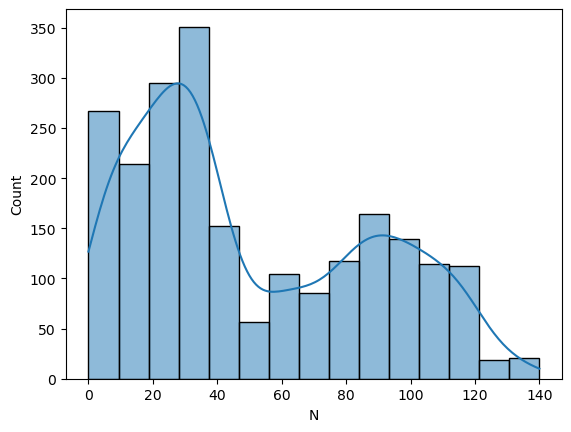

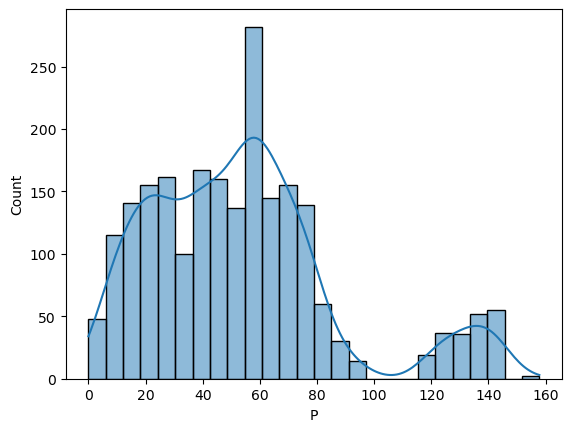

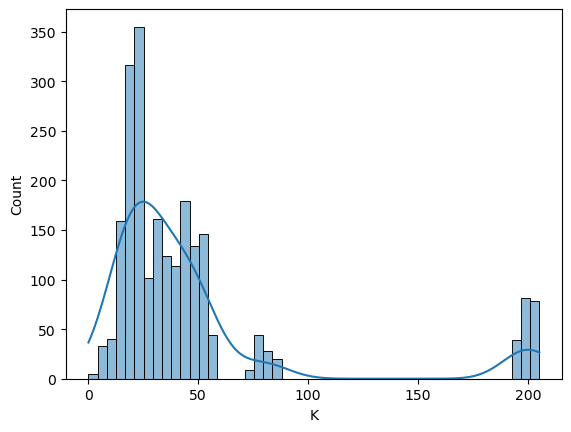

In [42]:
for col in ['N', 'P', 'K']:
    sns.histplot(df[col],kde=True)
    plt.show()

In [43]:
for col in ['N', 'P', 'K']:
    # Use IQR method to identify outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    
    if outliers_count > 0:
        print(f"{col} outliers: {outliers_count}")
        print(f"   Valid range: {lower_bound:.1f} to {upper_bound:.1f}")
        
        # Cap extreme outliers (beyond 3*IQR)
        extreme_upper = Q3 + 3 * IQR
        extreme_lower = Q1 - 3 * IQR
        
        extreme_outliers = ((df[col] < extreme_lower) | (df[col] > extreme_upper)).sum()
        if extreme_outliers > 0:
            df.loc[df[col] > extreme_upper, col] = extreme_upper
            df.loc[df[col] < extreme_lower, col] = extreme_lower
            print(f"   Capped {extreme_outliers} extreme outliers")

P outliers: 140
   Valid range: -32.0 to 128.0
K outliers: 198
   Valid range: -20.8 to 89.2
   Capped 198 extreme outliers


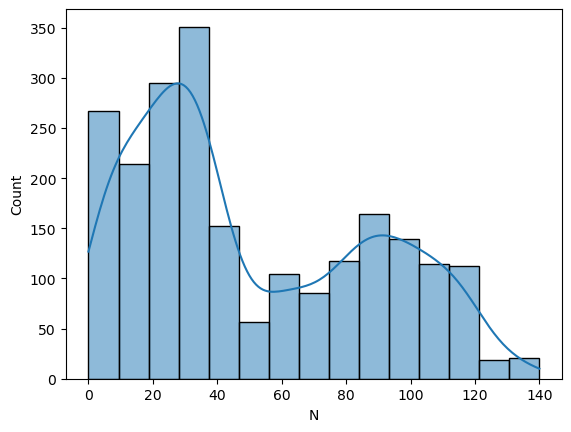

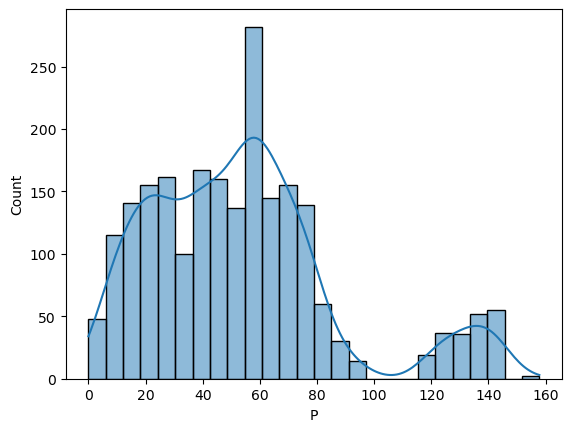

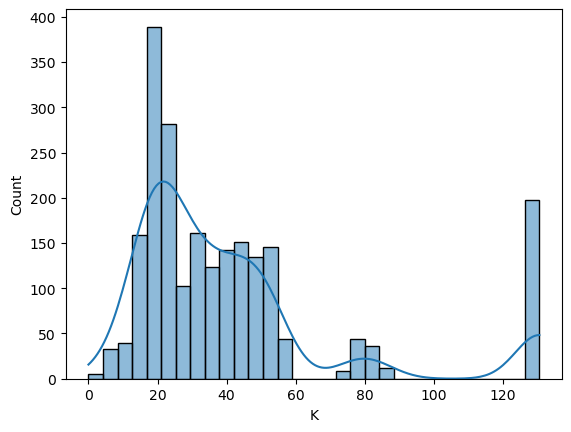

In [44]:
for col in ['N', 'P', 'K']:
    sns.histplot(df[col],kde=True)
    plt.show()

In [45]:
#Removing duplicates
initial_rows =len(df)

In [46]:
df_deduplicated = df.drop_duplicates()
len(df_deduplicated)

2200

In [47]:
exact_duplicates_removed = initial_rows - len(df_deduplicated)
exact_duplicates_removed

11

In [48]:
df = df_deduplicated.reset_index(drop=True)

In [49]:
len(df)

2200

In [50]:
#Final Data Quality Assessment 

In [51]:
df.shape

(2200, 8)

In [52]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [53]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.512727,53.330300,41.672955,25.634480,71.544612,6.461164,103.463655
std,36.954476,33.084192,32.133164,5.017346,22.710038,1.338475,54.958389
min,0.000000,0.000000,0.000000,8.825675,0.000000,0.000000,20.211267
25%,21.000000,28.000000,20.000000,22.812273,60.231681,5.955379,64.551686
50%,37.000000,51.000000,32.000000,25.617074,80.555916,6.426829,94.867624
75%,84.250000,68.000000,48.000000,28.546521,90.095555,6.932588,124.267508
max,140.000000,157.830011,130.500000,43.675493,100.000000,14.000000,298.560117


In [54]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [55]:
df.to_csv('crop_data_cleaned.csv', index=False)

*Exploratory Data Analysis (EDA)*

In [56]:
df = pd.read_csv('crop_data_cleaned.csv')

In [57]:
df.shape

(2200, 8)

In [58]:
numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
target_col = 'label'
print(f"Numeric columns: {numeric_cols}")
print(f"Target column: {target_col}")

Numeric columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
Target column: label


In [59]:
#UNIVARIATE ANALYSIS - FEATURE DISTRIBUTIONS

In [60]:
custom_params = {
    "axes.facecolor": "#F5F5DC",       # Light beige background
    "axes.edgecolor": "#2E7D32",       # Dark green axes lines
    "axes.labelcolor": "#2E7D32",      # Green axis labels
    "xtick.color": "#4CAF50",          # Medium green x-tick labels
    "ytick.color": "#4CAF50",          # Medium green y-tick labels
    "grid.color": "#D7CCC8",            # Light brown grid lines
    "grid.linestyle": "--",
    "font.family": "serif",             # A natural serif font
    "font.size": 12,
    "figure.facecolor": "#FFFFFF",      # White figure background
    "figure.edgecolor": "#FFFFFF",
    "lines.linewidth": 2,
    "legend.frameon": False,
    "legend.loc": "best",
    "text.color": "#2E7D32"
}

# Apply the custom theme globally
sns.set_theme(style="whitegrid", rc=custom_params)


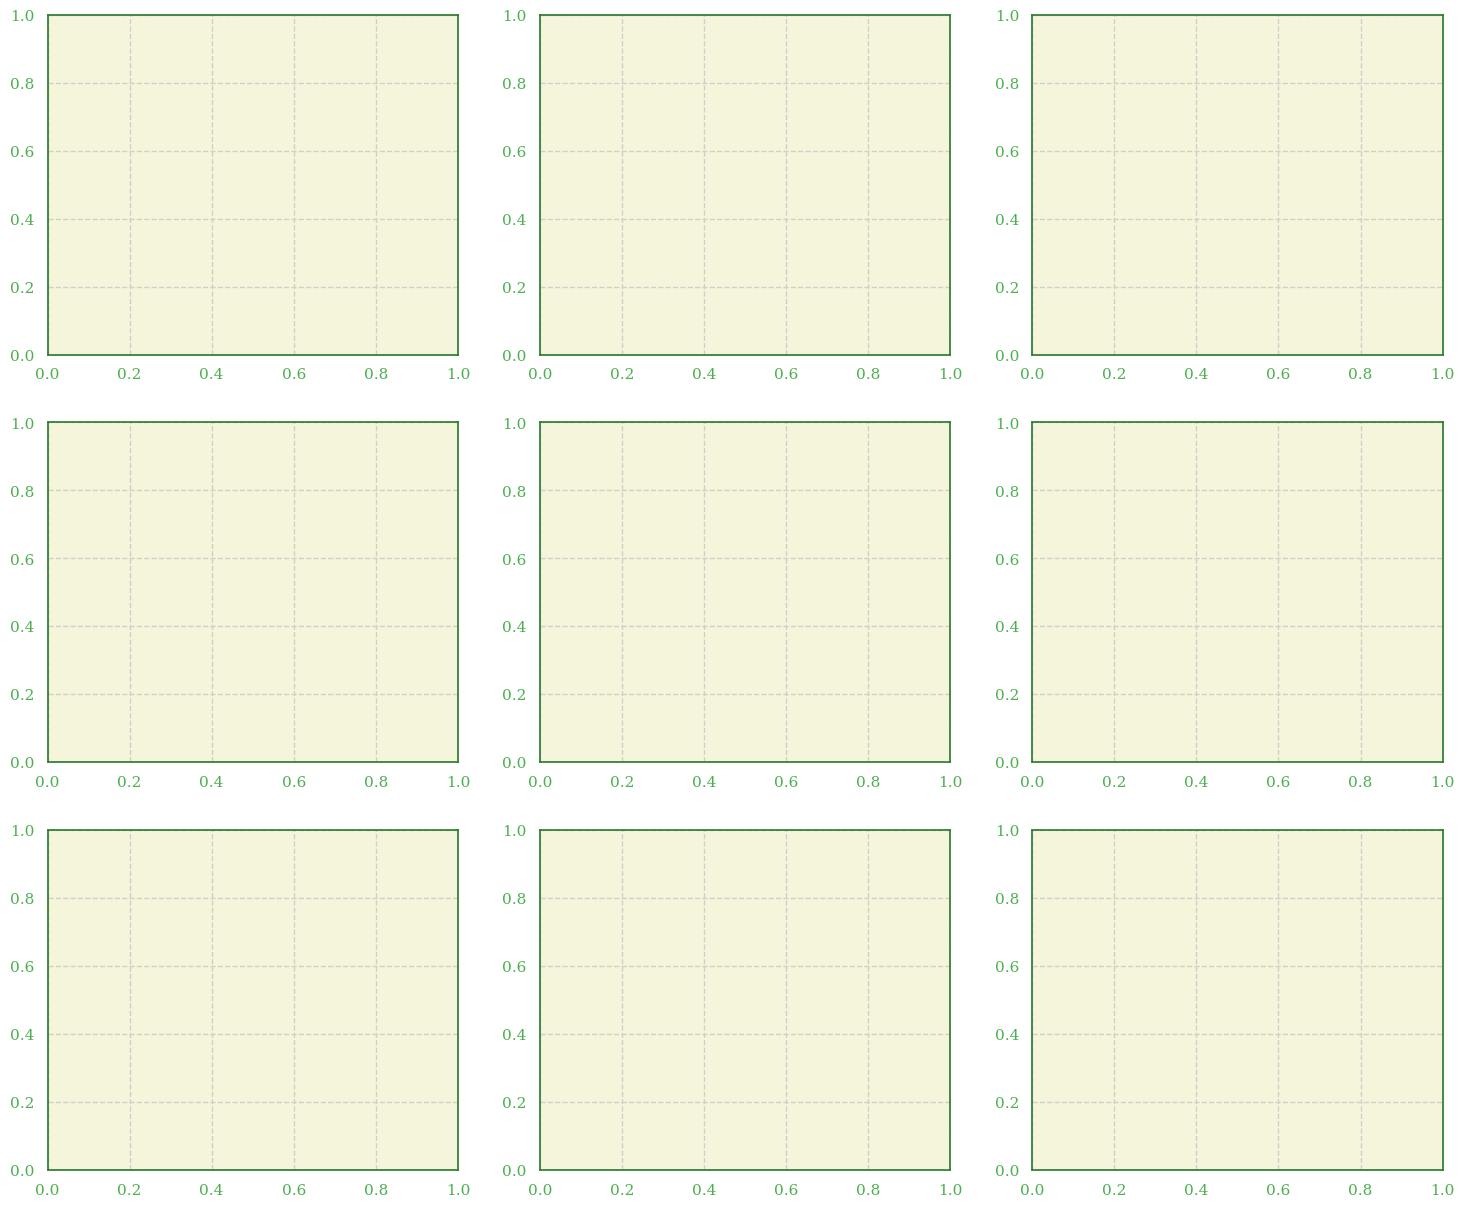

In [61]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

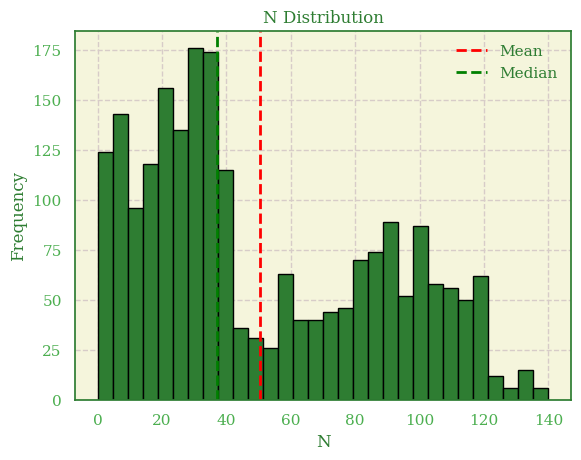

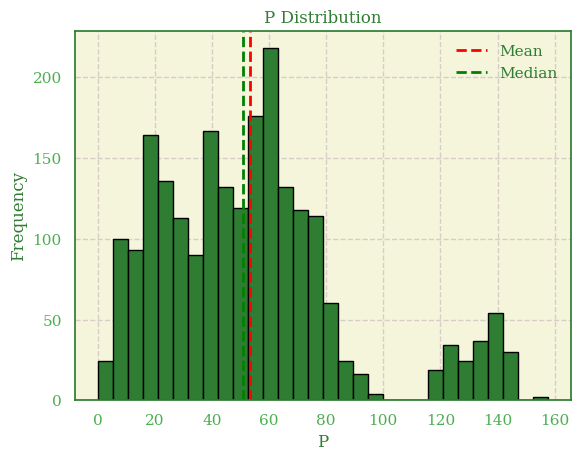

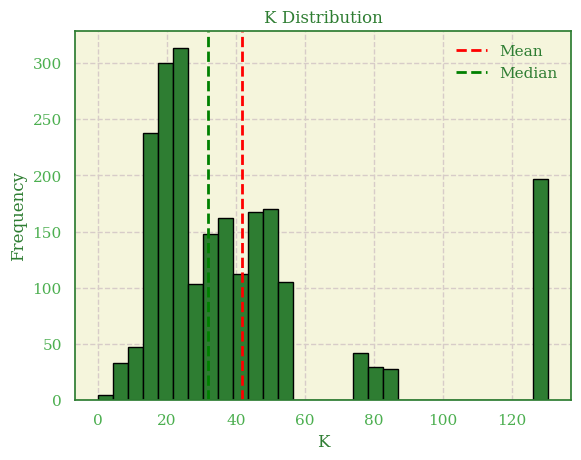

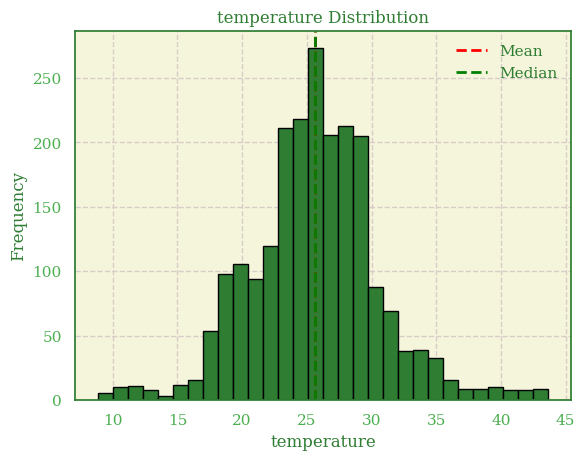

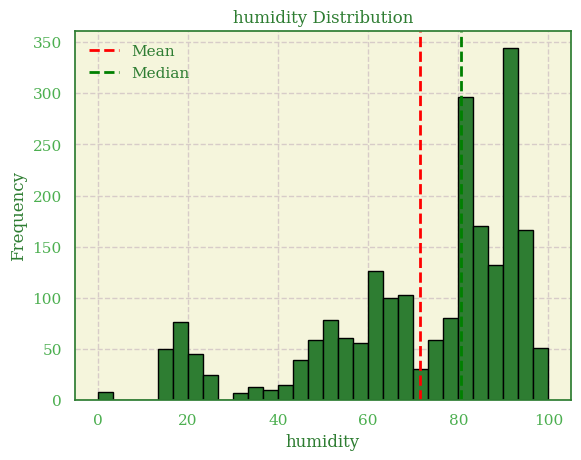

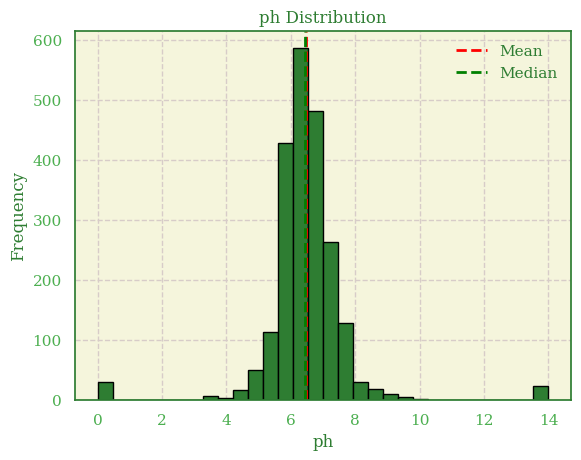

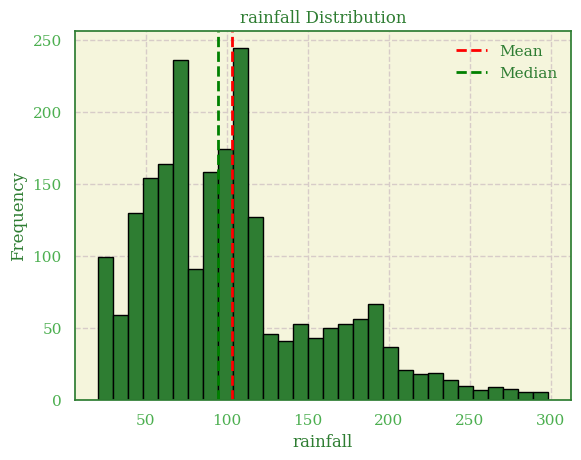

In [62]:
for col in numeric_cols:
    data = df[col]
    plt.hist(data, bins=30, color="#2E7D32", edgecolor='black')
    
    # Mean and median lines
    plt.axvline(data.mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(data.median(), color='green', linestyle='--', label='Median')
    
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


In [63]:
df[numeric_cols].describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.512727,53.330300,41.672955,25.634480,71.544612,6.461164,103.463655
std,36.954476,33.084192,32.133164,5.017346,22.710038,1.338475,54.958389
min,0.000000,0.000000,0.000000,8.825675,0.000000,0.000000,20.211267
25%,21.000000,28.000000,20.000000,22.812273,60.231681,5.955379,64.551686
50%,37.000000,51.000000,32.000000,25.617074,80.555916,6.426829,94.867624
75%,84.250000,68.000000,48.000000,28.546521,90.095555,6.932588,124.267508
max,140.000000,157.830011,130.500000,43.675493,100.000000,14.000000,298.560117


In [64]:
df[numeric_cols].skew()

N              0.508255
P              1.016147
K              1.801906
temperature    0.175084
humidity      -1.110677
ph             0.421416
rainfall       0.965756
dtype: float64

<Axes: >

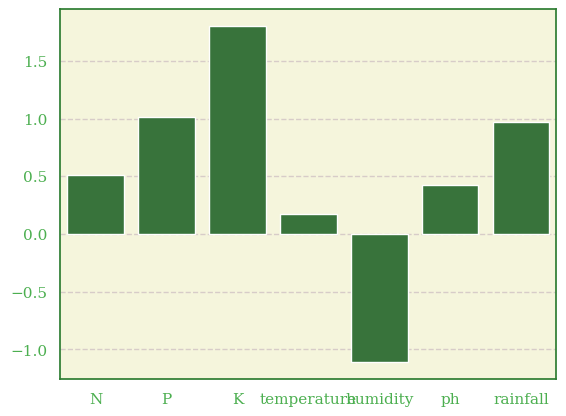

In [65]:
sns.barplot(df[numeric_cols].skew(),color="#2E7D32")

In [66]:
df[numeric_cols].kurtosis(),
# ph has high kurtosis because we capped the values between 0 and 14 leading to higher values of 0 and 14

(N              -1.059398
 P               0.882107
 K               2.477862
 temperature     1.274287
 humidity        0.398912
 ph             16.197235
 rainfall        0.607079
 dtype: float64,)

<Axes: >

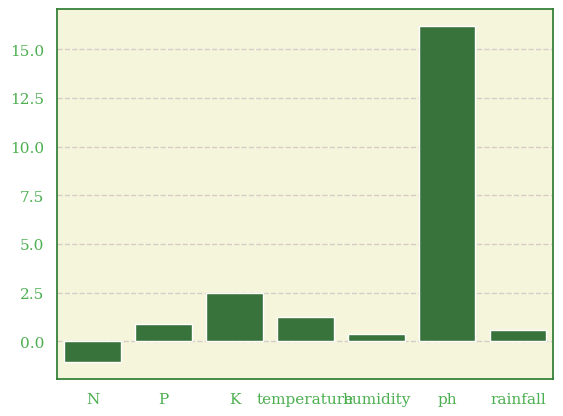

In [67]:
sns.barplot(df[numeric_cols].kurtosis(),color="#2E7D32")

In [68]:
df[numeric_cols].var()

N              1365.633308
P              1094.563732
K              1032.540219
temperature      25.173762
humidity        515.745812
ph                1.791515
rainfall       3020.424469
dtype: float64

<Axes: >

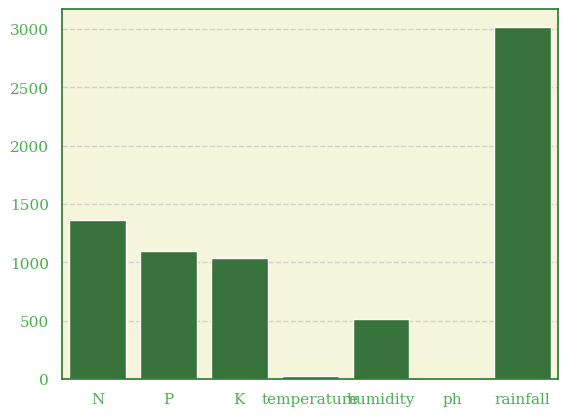

In [69]:
sns.barplot(df[numeric_cols].var(),color="#2E7D32")

In [70]:
df[numeric_cols].max() - df[numeric_cols].min()

N              140.000000
P              157.830011
K              130.500000
temperature     34.849818
humidity       100.000000
ph              14.000000
rainfall       278.348850
dtype: float64

<Axes: >

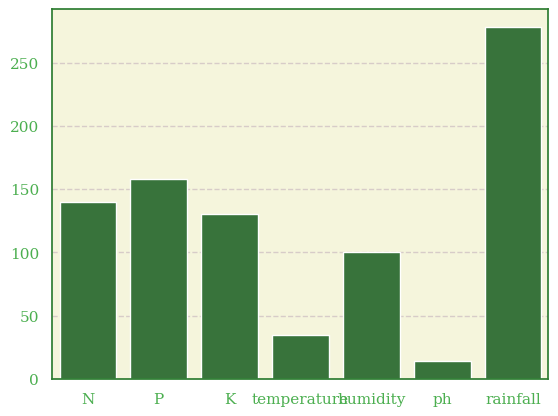

In [71]:
sns.barplot(df[numeric_cols].max() - df[numeric_cols].min(),color="#2E7D32")

In [72]:
# Target Variable Analysis

In [73]:
df[target_col].value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

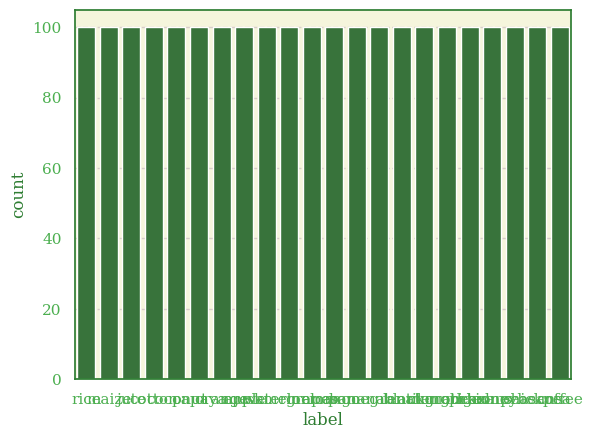

In [74]:
sns.barplot(df[target_col].value_counts(),color="#2E7D32")

In [75]:
# Correlation Analysis

In [76]:
correlation_matrix = df[numeric_cols].corr()
correlation_matrix

,N,P,K,temperature,humidity,ph,rainfall
N,1.000000,-0.231738,-0.060617,0.026281,0.188119,0.047872,0.057974
P,-0.231738,1.000000,0.653758,-0.126408,-0.123607,-0.074546,-0.064088
K,-0.060617,0.653758,1.000000,-0.154074,0.136045,-0.099701,-0.031799
temperature,0.026281,-0.126408,-0.154074,1.000000,0.195725,-0.007046,-0.030904
humidity,0.188119,-0.123607,0.136045,0.195725,1.000000,0.000260,0.092804
ph,0.047872,-0.074546,-0.099701,-0.007046,0.000260,1.000000,-0.061571
rainfall,0.057974,-0.064088,-0.031799,-0.030904,0.092804,-0.061571,1.000000


In [77]:
# Find strong correlations (|r| > 0.3)
threshold = 0.3
strong_corrs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > threshold:
            strong_corrs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr))

# Print results
if strong_corrs:
    strong_corrs.sort(key=lambda x: abs(x[2]), reverse=True)
    print("\nStrong Correlations (|r| > 0.3):")
    for v1, v2, val in strong_corrs:
        print(f"{v1} ↔ {v2}: {val:.3f}")
else:
    print("\nNo strong correlations found.")



Strong Correlations (|r| > 0.3):
P ↔ K: 0.654


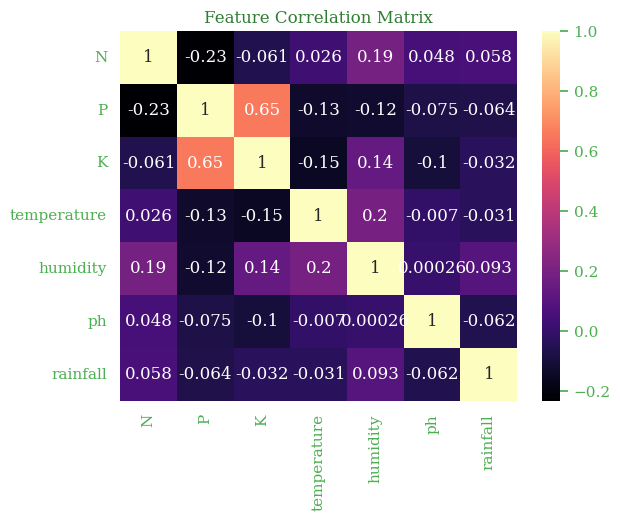

In [78]:
sns.heatmap(correlation_matrix, annot=True, cmap='magma')
plt.title('Feature Correlation Matrix')
plt.show()

In [79]:
#BIVARIATE ANALYSIS - FEATURES vs TARGET

Text(0.5, 1.0, 'Average Feature Values by Crop')

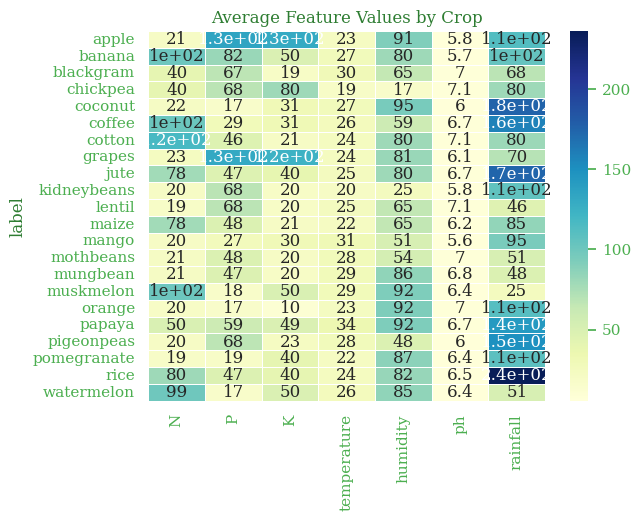

In [80]:
crop_means = df.groupby(target_col)[numeric_cols].mean().round(2)
crop_means
sns.heatmap(crop_means, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Average Feature Values by Crop")

In [81]:
#pH 6-7 optimal for >80% of crops

In [82]:
from scipy import stats

N: F=896.55, p=0.000 ✓
P: F=1529.66, p=0.000 ✓
K: F=1589.51, p=0.000 ✓
temperature: F=97.54, p=0.000 ✓
humidity: F=821.15, p=0.000 ✓
ph: F=15.06, p=0.000 ✓
rainfall: F=605.53, p=0.000 ✓


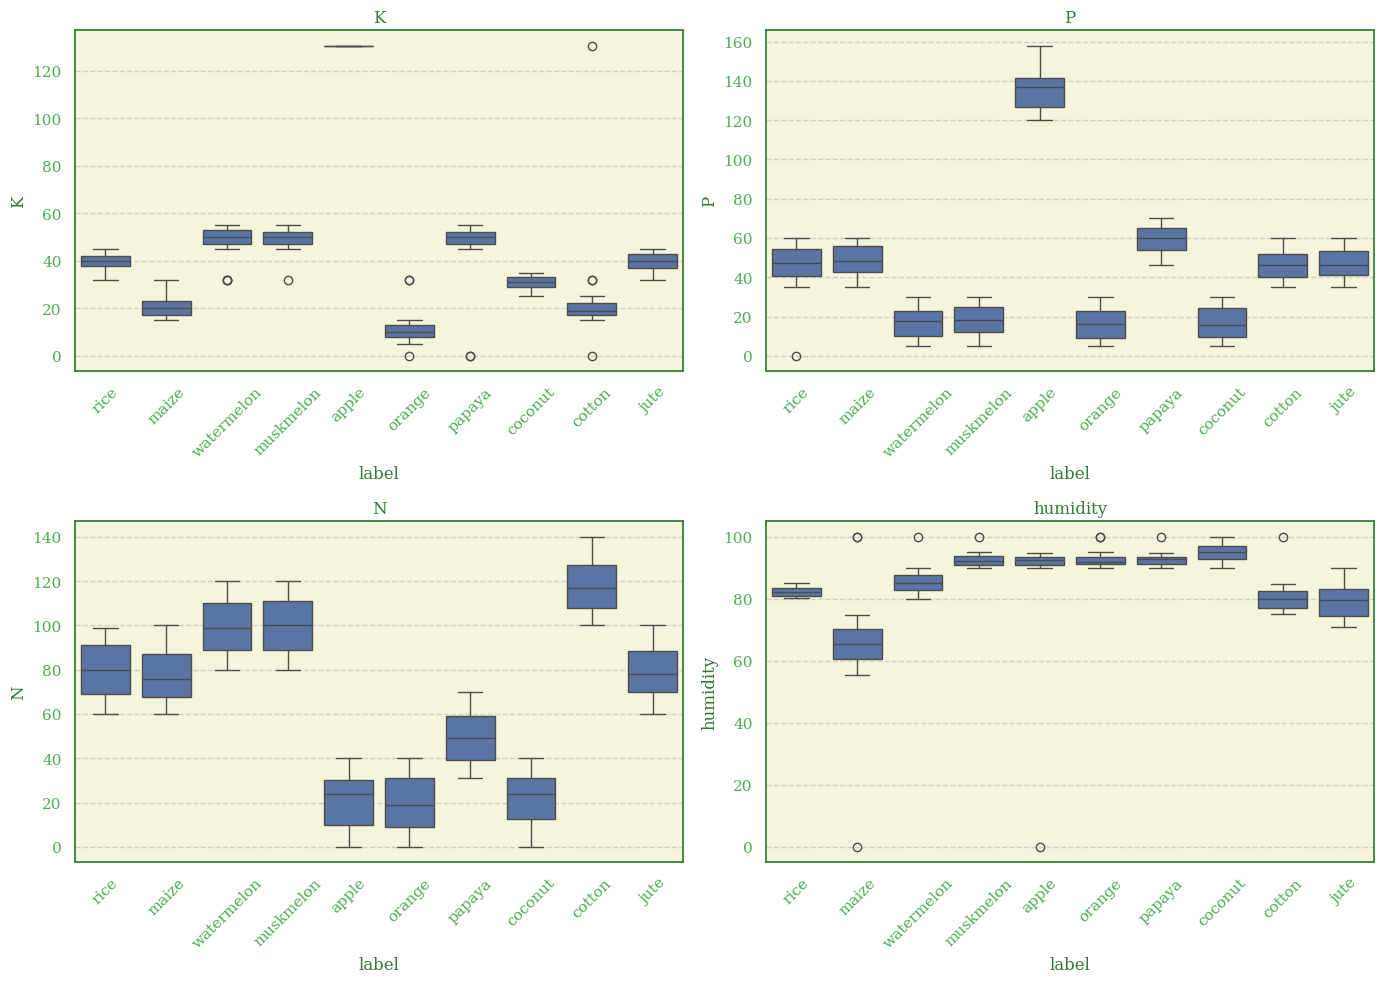

In [83]:
top_10_crops = df[target_col].value_counts().head(10).index
results = {}
for f in numeric_cols:
    groups = [g[f].values for _, g in df.groupby(target_col)]
    F, p = stats.f_oneway(*groups)
    results[f] = F, p
    print(f"{f}: F={F:.2f}, p={p:.3f} {'✓' if p < 0.05 else '✗'}")

# Get top 4 features by F-stat
top_feats = sorted(results, key=lambda x: results[x][0], reverse=True)[:4]

# Plot boxplots for top 10 crops and top features
df_top = df[df[target_col].isin(top_10_crops)]
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for ax, feat in zip(axs.flatten(), top_feats):
    sns.boxplot(data=df_top, x=target_col, y=feat, ax=ax)
    ax.set_title(feat)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [84]:
#Features like N, P, K (nutrients), and temperature, humidity, pH, rainfall all show meaningful differences between crops.
#These features are likely important factors in distinguishing one crop’s ideal conditions from another’s.

Feature Engineering

In [85]:
df_fe = df.copy()
new_features = []

In [86]:
#NPK FEATURES

In [87]:
df_fe['npk_total'] = df_fe['N'] + df_fe['P'] + df_fe['K']
new_features.append('npk_total')

In [88]:
npk_std = df_fe[['N', 'P', 'K']].std(axis=1)

In [89]:
npk_mean = df_fe[['N', 'P', 'K']].mean(axis=1)

In [90]:
df_fe['npk_balance_score'] = 1 / (1 + npk_std / npk_mean)  # Higher = more balanced

In [91]:
new_features.append('npk_balance_score')

In [92]:
print(f"✓ npk_balance_score: {df_fe['npk_balance_score'].min():.3f} to {df_fe['npk_balance_score'].max():.3f}")

✓ npk_balance_score: 0.403 to 0.983


In [93]:
#CLIMATE & SOIL CATEGORIES

In [94]:
def get_climate_zone(temp, humidity):
    if temp >= 25 and humidity >= 70:
        return 'Hot_Humid'
    elif temp >= 25 and humidity < 70:
        return 'Hot_Dry'
    elif temp < 25 and humidity >= 70:
        return 'Cool_Humid'
    else:
        return 'Cool_Dry'

In [95]:
df_fe['climate_zone'] = df_fe.apply(lambda x: get_climate_zone(x['temperature'], x['humidity']), axis=1)

In [96]:
new_features.append('climate_zone')

In [97]:
climate_dist = df_fe['climate_zone'].value_counts()
climate_dist

climate_zone
Hot_Humid     768
Cool_Humid    561
Hot_Dry       484
Cool_Dry      387
Name: count, dtype: int64

In [98]:
# 2. pH Level
df_fe['ph_level'] = pd.cut(
    df_fe['ph'],
    bins=[0, 6.5, 7.5, 14],
    labels=['Acidic', 'Neutral', 'Alkaline']
)
new_features.append('ph_level')

In [99]:
ph_dist = df_fe['ph_level'].value_counts()
ph_dist

ph_level
Acidic      1169
Neutral      798
Alkaline     202
Name: count, dtype: int64

In [100]:
# 3. Rainfall Category
df_fe['rainfall_category'] = pd.cut(
    df_fe['rainfall'],
    bins=[0, 150, 250, 500],
    labels=['Low', 'Medium', 'High']
)
new_features.append('rainfall_category')

In [101]:
rain_dist = df_fe['rainfall_category'].value_counts()
rain_dist

rainfall_category
Low       1775
Medium     387
High        38
Name: count, dtype: int64

In [102]:
#Growing Conditions Score-A Growing Conditions Score assesses the suitability of an environment for plant growth by evaluating factors like soil quality, water availability, temperature, and sunlight. This score helps determine the potential for a plant to thrive in a particular location or under specific conditions.
#composite growing conditions score (0-100 scale)

In [103]:
# Normalize each component (0-1 scale)
temp_score = 1 - abs(df_fe['temperature'] - 25) / 25  # Optimal around 25°C
humidity_score = 1 - abs(df_fe['humidity'] - 65) / 65  # Optimal around 65%
ph_score = 1 - abs(df_fe['ph'] - 7) / 7  # Optimal around pH 7
npk_score = df_fe['npk_balance_score']  # Already 0-1 scale

In [104]:
# Ensure all scores are between 0 and 1
temp_score = np.clip(temp_score, 0, 1)
humidity_score = np.clip(humidity_score, 0, 1)
ph_score = np.clip(ph_score, 0, 1)
temp_score,humidity_score,ph_score

(0       0.835190
 1       0.870818
 2       0.920178
 3       0.940356
 4       0.805207
           ...   
 2195    0.929015
 2196    0.903316
 2197    0.965272
 2198    0.949103
 2199    0.944121
 Name: temperature, Length: 2200, dtype: float64,
 0       0.738419
 1       0.764313
 2       0.733527
 3       0.766794
 4       0.744540
           ...   
 2195    0.978257
 2196    0.871329
 2197    0.965767
 2198    0.801960
 2199    0.929177
 Name: humidity, Length: 2200, dtype: float64,
 0       0.928998
 1       0.994558
 2       0.879970
 3       0.997200
 4       0.910218
           ...   
 2195    0.968581
 2196    0.869560
 2197    0.908944
 2198    0.965542
 2199    0.968548
 Name: ph, Length: 2200, dtype: float64)

In [105]:
df_fe['growing_conditions_score'] = (
    temp_score * 0.3 +      # 30% weight- most important 
    humidity_score * 0.25 +  # 25% weight
    ph_score * 0.25 +       # 25% weight
    npk_score * 0.2         # 20% weight
) * 100

In [106]:
new_features.append('growing_conditions_score')

In [107]:
score_ranges = pd.cut(df_fe['growing_conditions_score'], bins=[0, 40, 60, 80, 100], 
                     labels=['Poor', 'Fair', 'Good', 'Excellent'])
score_dist = score_ranges.value_counts()
score_dist

growing_conditions_score
Good         1156
Excellent     984
Fair           59
Poor            1
Name: count, dtype: int64

In [108]:
print(f"Original features: 7")
print(f"New features created: {len(new_features)}")
print(f"Total features: {df_fe.shape[1] - 1} (excluding target)")

print(f"\n📋 New Features Created:")
print(f"   1. npk_total              (Numeric) - Sum of all nutrients")
print(f"   2. npk_balance_score      (Numeric) - Nutrient balance (0-1)")
print(f"   3. climate_zone           (Category) - 4 climate types")
print(f"   4. ph_level               (Category) - Acidic/Neutral/Alkaline")
print(f"   5. rainfall_category      (Category) - Low/Medium/High")
print(f"   6. growing_conditions_score (Numeric) - Overall score (0-100)")


Original features: 7
New features created: 6
Total features: 13 (excluding target)

📋 New Features Created:
   1. npk_total              (Numeric) - Sum of all nutrients
   2. npk_balance_score      (Numeric) - Nutrient balance (0-1)
   3. climate_zone           (Category) - 4 climate types
   4. ph_level               (Category) - Acidic/Neutral/Alkaline
   5. rainfall_category      (Category) - Low/Medium/High
   6. growing_conditions_score (Numeric) - Overall score (0-100)


In [109]:
df_fe.to_csv('crop_data_with_features.csv', index=False)

In [110]:
df_fe.head(10)

,N,P,K,temperature,humidity,ph,rainfall,label,npk_total,npk_balance_score,climate_zone,ph_level,rainfall_category,growing_conditions_score
0,90.0,42.0,43.0,20.879744,82.002744,6.502985,202.935536,rice,175.0,0.680177,Cool_Humid,Neutral,Medium,80.344657
1,85.0,58.0,41.0,21.770462,80.319644,7.038096,226.655537,rice,184.0,0.734338,Cool_Humid,Neutral,Medium,84.783088
2,60.0,55.0,44.0,23.004459,82.320763,7.840207,263.964248,rice,159.0,0.866220,Cool_Humid,Alkaline,High,85.267187
3,74.0,35.0,40.0,26.491096,80.158363,6.980401,242.864034,rice,149.0,0.700638,Hot_Humid,Neutral,Medium,86.323317
4,78.0,42.0,42.0,20.130175,81.604873,7.628473,262.717340,rice,162.0,0.722074,Cool_Humid,Alkaline,High,79.966648
5,69.0,37.0,42.0,23.058049,83.370118,7.073454,251.055000,rice,148.0,0.741323,Cool_Humid,Neutral,High,85.168359
6,69.0,55.0,38.0,22.708838,82.639414,5.700806,271.324860,rice,162.0,0.776708,Cool_Humid,Acidic,High,81.360401
7,94.0,53.0,40.0,20.277744,82.894086,5.718627,241.974195,rice,187.0,0.688635,Cool_Humid,Acidic,Medium,76.647317
8,89.0,54.0,38.0,24.515881,83.535216,6.685346,230.446236,rice,181.0,0.698169,Cool_Humid,Neutral,Medium,85.129742
9,68.0,58.0,38.0,23.223974,83.033227,6.336254,221.209196,rice,164.0,0.781601,Cool_Humid,Acidic,Medium,84.194407


In [111]:
df_fe['temperature_stress'] = abs(df_fe['temperature'] - 25) / 25  # 25°C is optimal
print(f"   4. temperature_stress: {df_fe['temperature_stress'].min():.3f} to {df_fe['temperature_stress'].max():.3f}")


   4. temperature_stress: 0.000 to 0.747


In [112]:
df_fe


,N,P,K,temperature,humidity,ph,rainfall,label,npk_total,npk_balance_score,climate_zone,ph_level,rainfall_category,growing_conditions_score,temperature_stress
0,90.0,42.0,43.0,20.879744,82.002744,6.502985,202.935536,rice,175.0,0.680177,Cool_Humid,Neutral,Medium,80.344657,0.164810
1,85.0,58.0,41.0,21.770462,80.319644,7.038096,226.655537,rice,184.0,0.734338,Cool_Humid,Neutral,Medium,84.783088,0.129182
2,60.0,55.0,44.0,23.004459,82.320763,7.840207,263.964248,rice,159.0,0.866220,Cool_Humid,Alkaline,High,85.267187,0.079822
3,74.0,35.0,40.0,26.491096,80.158363,6.980401,242.864034,rice,149.0,0.700638,Hot_Humid,Neutral,Medium,86.323317,0.059644
4,78.0,42.0,42.0,20.130175,81.604873,7.628473,262.717340,rice,162.0,0.722074,Cool_Humid,Alkaline,High,79.966648,0.194793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,107.0,34.0,32.0,26.774637,66.413269,6.780064,177.774507,coffee,173.0,0.574356,Hot_Dry,Neutral,Medium,88.028506,0.070985
2196,99.0,15.0,27.0,27.417112,56.636362,6.086922,127.924610,coffee,141.0,0.508486,Hot_Dry,Acidic,Low,80.791409,0.096684
2197,118.0,33.0,30.0,24.131797,67.225123,6.362608,173.322839,coffee,181.0,0.547010,Cool_Dry,Acidic,Medium,86.766132,0.034728
2198,117.0,32.0,34.0,26.272418,52.127394,6.758793,127.175293,coffee,183.0,0.557038,Hot_Dry,Neutral,Low,83.801406,0.050897


In [113]:
df_fe.head()


,N,P,K,temperature,humidity,ph,rainfall,label,npk_total,npk_balance_score,climate_zone,ph_level,rainfall_category,growing_conditions_score,temperature_stress
0,90.0,42.0,43.0,20.879744,82.002744,6.502985,202.935536,rice,175.0,0.680177,Cool_Humid,Neutral,Medium,80.344657,0.164810
1,85.0,58.0,41.0,21.770462,80.319644,7.038096,226.655537,rice,184.0,0.734338,Cool_Humid,Neutral,Medium,84.783088,0.129182
2,60.0,55.0,44.0,23.004459,82.320763,7.840207,263.964248,rice,159.0,0.866220,Cool_Humid,Alkaline,High,85.267187,0.079822
3,74.0,35.0,40.0,26.491096,80.158363,6.980401,242.864034,rice,149.0,0.700638,Hot_Humid,Neutral,Medium,86.323317,0.059644
4,78.0,42.0,42.0,20.130175,81.604873,7.628473,262.717340,rice,162.0,0.722074,Cool_Humid,Alkaline,High,79.966648,0.194793
